In [ ]:
#solo para Google Colab
!pip install geopandas

In [42]:
#Librerías
import pandas as pd
import geopandas as gpd
import sys
import tqdm
sys.path.append(r"C:\Users\mfpen\Documents\Repositorios\geoloc2\preparacion_datos")
from funciones_cruces_limpieza import *
sys.path.append(r"C:\Users\mfpen\Documents\Repositorios\geoloc2\Valor_Catastral")
from Herramientas import cruzar_chinchetas_vs_dnue
sys.path.append(r'C:\Users\mfpen\Documents\Repositorios\geoloc2\Detecciondeterrenos')
from codigos import obtener_curt

# from google.colab import drive
# drive.mount('/content/drive')

In [76]:
#Rutas de bases
# Usar el de casas original
path_casas =r"H:\.shortcut-targets-by-id\19j98C-PJkrk3gkgU7V03dLiJ4Gn-hnNe\geoshaps\Atlacomulco\Rotacion_Atlacomulco\prueba_deteccion_3_rotacion.shp"
#CURT Municipal
path_CURT =r"D:\Secretaria\Bases_shp_INEGI\CURT\024 Atlacomulco\ATLACOMULCO_PREDIOS.shp"
#Industias filtro
path_industrias = r"H:\.shortcut-targets-by-id\19j98C-PJkrk3gkgU7V03dLiJ4Gn-hnNe\geoshaps\Atlacomulco\industria\Atlaco_industrias_filtro.shp"
#Usar chinchetas vs denue o la original
path_chinchetas = r"H:\.shortcut-targets-by-id\19j98C-PJkrk3gkgU7V03dLiJ4Gn-hnNe\geoshaps\Atlacomulco\atlacomulco_3105\Salidas\Chinchetas_atlacomulco\Chinchetas_atlacomulco_limpio.shp"
# Usar DENUE_EDOMEX_2022 en Estatal de Geoshaps o en Geo -> Data -> Bases_shp_INEGI -> DENUE -> (Municipio.shape)
path_denue =r"I:\Mi unidad\Cruces_predial_otros\DENUE\Atlacomulco.shp"
#Usar base de zonas rurales y urbanas
path_zonas = r"H:\.shortcut-targets-by-id\1xy7wVmj8pxJHqeyV9CG1vOBQs3emChdq\Geo\Data\bases_shp_INEGI\zonas_rurales_urbanas\15m.shp"



In [79]:
#Carga de bases
casas = gpd.read_file(path_casas)
CURT_mun = gpd.read_file(path_CURT)
industrias=gpd.read_file(path_industrias)
pines = gpd.read_file(path_chinchetas)
denue = gpd.read_file(path_denue)
zonas = gpd.read_file(path_zonas)

Cruce de CURT x predicción de casas

In [4]:
#Revisar que corresponda la base de casas únicamente a casas
casas.clase_dete.value_counts()

establecimiento    36247
casas              21329
terreno_baldio       923
en_construccion        3
multivivienda          1
Name: clase_dete, dtype: int64

In [5]:
#Filtrar para que no contenga las predicciones de terreno_baldio
casas=casas[casas.clase_dete != 'terreno_baldio']
casas

,clase_dete,conf,area,status,geometry
0,establecimiento,0.70136,511.425330,correcto,"POLYGON ((-11128888.95573 2257450.58082, -1112..."
1,casas,0.82655,182.508647,correcto,"POLYGON ((-11128894.36396 2257458.17207, -1112..."
2,establecimiento,0.55637,322.899914,correcto,"POLYGON ((-11128702.18241 2256321.84985, -1112..."
3,establecimiento,0.55807,465.296771,correcto,"POLYGON ((-11128709.79818 2256311.39002, -1112..."
4,establecimiento,0.65544,187.522621,correcto,"POLYGON ((-11128695.31023 2256334.84175, -1112..."
...,...,...,...,...,...
58497,establecimiento,0.27976,1504.192146,correcto,"POLYGON ((-11100394.03587 2243756.81697, -1110..."
58498,establecimiento,0.38781,1073.993192,correcto,"POLYGON ((-11100399.98801 2243752.76801, -1110..."
58500,establecimiento,0.62800,210.586900,correcto,"POLYGON ((-11099543.48043 2242089.02879, -1109..."
58501,establecimiento,0.24212,195.544979,correcto,"POLYGON ((-11099434.89340 2243549.85882, -1109..."


In [6]:
#Se le asigna un ID 
casas["ID_casas"]=casas.index
casas

,clase_dete,conf,area,status,geometry,ID_casas
0,establecimiento,0.70136,511.425330,correcto,"POLYGON ((-11128888.95573 2257450.58082, -1112...",0
1,casas,0.82655,182.508647,correcto,"POLYGON ((-11128894.36396 2257458.17207, -1112...",1
2,establecimiento,0.55637,322.899914,correcto,"POLYGON ((-11128702.18241 2256321.84985, -1112...",2
3,establecimiento,0.55807,465.296771,correcto,"POLYGON ((-11128709.79818 2256311.39002, -1112...",3
4,establecimiento,0.65544,187.522621,correcto,"POLYGON ((-11128695.31023 2256334.84175, -1112...",4
...,...,...,...,...,...,...
58497,establecimiento,0.27976,1504.192146,correcto,"POLYGON ((-11100394.03587 2243756.81697, -1110...",58497
58498,establecimiento,0.38781,1073.993192,correcto,"POLYGON ((-11100399.98801 2243752.76801, -1110...",58498
58500,establecimiento,0.62800,210.586900,correcto,"POLYGON ((-11099543.48043 2242089.02879, -1109...",58500
58501,establecimiento,0.24212,195.544979,correcto,"POLYGON ((-11099434.89340 2243549.85882, -1109...",58501


In [7]:
#Se revisa el CRS de cada base para poder hacer el cruce entre ellas
print("crs CURT: ",CURT_mun.crs)
print("crs casas: ",casas.crs)

crs CURT:  EPSG:4326
crs casas:  LOCAL_CS["WGS 84 / Pseudo-Mercator",LOCAL_DATUM["Unknown engineering datum",32767],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [8]:
#Configuración de la geometría para poder realizar el cruce x predicción
CURT_mun=CURT_mun.set_crs(6364,allow_override=True)
CURT_mun=CURT_mun.to_crs(3857)
CURT_mun.geometry

0       POLYGON ((-11118026.626 2248851.074, -11118027...
1       POLYGON ((-11119261.940 2248599.490, -11119271...
2       POLYGON ((-11119261.940 2248599.490, -11119247...
3       POLYGON ((-11117414.936 2250171.302, -11117419...
4       POLYGON ((-11118026.626 2248851.074, -11118017...
                              ...                        
1919    POLYGON ((-11117270.073 2248025.083, -11117265...
1920    POLYGON ((-11117276.877 2248038.361, -11117270...
1921    POLYGON ((-11117284.711 2248059.038, -11117276...
1922    POLYGON ((-11117320.510 2248056.753, -11117335...
1923    POLYGON ((-11117291.290 2248079.719, -11117288...
Name: geometry, Length: 1924, dtype: geometry

In [9]:
#Configuración de la geometría para poder realizar el cruce x curt
casas=casas.set_crs(3857,allow_override=True)
casas.geometry

0        POLYGON ((-11128888.956 2257450.581, -11128884...
1        POLYGON ((-11128894.364 2257458.172, -11128890...
2        POLYGON ((-11128702.182 2256321.850, -11128697...
3        POLYGON ((-11128709.798 2256311.390, -11128704...
4        POLYGON ((-11128695.310 2256334.842, -11128692...
                               ...                        
58497    POLYGON ((-11100394.036 2243756.817, -11100369...
58498    POLYGON ((-11100399.988 2243752.768, -11100383...
58500    POLYGON ((-11099543.480 2242089.029, -11099532...
58501    POLYGON ((-11099434.893 2243549.859, -11099430...
58502    POLYGON ((-11099425.118 2242077.771, -11099392...
Name: geometry, Length: 57580, dtype: geometry

In [10]:
#Se crea la variable CURT_f 
casas=obtener_curt(casas,'geometry')
casas

,clase_dete,conf,area,status,geometry,ID_casas,CURT_f
0,establecimiento,0.70136,511.425330,correcto,"POLYGON ((-11128888.956 2257450.581, -11128884...",0,19520650389958203663
1,casas,0.82655,182.508647,correcto,"POLYGON ((-11128894.364 2257458.172, -11128890...",1,19520678009958209589
2,establecimiento,0.55637,322.899914,correcto,"POLYGON ((-11128702.182 2256321.850, -11128697...",2,19513214269958144775
3,establecimiento,0.55807,465.296771,correcto,"POLYGON ((-11128709.798 2256311.390, -11128704...",3,19513178869958145855
4,establecimiento,0.65544,187.522621,correcto,"POLYGON ((-11128695.310 2256334.842, -11128692...",4,19513244849958143840
...,...,...,...,...,...,...,...
58497,establecimiento,0.27976,1504.192146,correcto,"POLYGON ((-11100394.036 2243756.817, -11100369...",58497,19450946459942583913
58498,establecimiento,0.38781,1073.993192,correcto,"POLYGON ((-11100399.988 2243752.768, -11100383...",58498,19450920559942586858
58500,establecimiento,0.62800,210.586900,correcto,"POLYGON ((-11099543.480 2242089.029, -11099532...",58500,19441895799942316247
58501,establecimiento,0.24212,195.544979,correcto,"POLYGON ((-11099434.893 2243549.859, -11099430...",58501,19450350719942281620


In [11]:
#Se borran duplicados a partir de la CURT generada
casas.drop_duplicates(subset='CURT_f',inplace=True)

In [12]:
CURT_mun.shape, casas.shape

((1924, 7), (57580, 7))

In [13]:
cruce_curt=gpd.sjoin(CURT_mun,casas)
cruce_curt#.shape

,cve_ent,cve_mun,cve_loc,id_cat,curt,notas,geometry,index_right,clase_dete,conf,area,status,ID_casas,CURT_f
0,15,024,0000,0240144801000000,194744919109952299131,NaN,"POLYGON ((-11118026.626 2248851.074, -11118027...",31445,casas,0.35628,561.565068,correcto,31445,19474431089952303057
4,15,024,0000,0240144837000000,194744232409952299340,NaN,"POLYGON ((-11118026.626 2248851.074, -11118017...",31445,casas,0.35628,561.565068,correcto,31445,19474431089952303057
0,15,024,0000,0240144801000000,194744919109952299131,NaN,"POLYGON ((-11118026.626 2248851.074, -11118027...",32129,establecimiento,0.45533,361.006115,correcto,32129,19474441869952297796
4,15,024,0000,0240144837000000,194744232409952299340,NaN,"POLYGON ((-11118026.626 2248851.074, -11118017...",32129,establecimiento,0.45533,361.006115,correcto,32129,19474441869952297796
0,15,024,0000,0240144801000000,194744919109952299131,NaN,"POLYGON ((-11118026.626 2248851.074, -11118027...",32130,establecimiento,0.45707,140.391267,correcto,32130,19474460699952299548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1897,15,024,0000,0240147019000000,194838722209951267616,NaN,"POLYGON ((-11116090.129 2250610.380, -11116091...",41159,casas,0.37332,140.391267,correcto,41159,19483871169951267208
1900,15,024,0000,0240144236000000,194827684709952076215,NaN,"POLYGON ((-11117282.590 2250268.896, -11117312...",36387,casas,0.31278,877.445419,correcto,36387,19482696059952067821
1900,15,024,0000,0240144236000000,194827684709952076215,NaN,"POLYGON ((-11117282.590 2250268.896, -11117312...",36389,establecimiento,0.35705,375.045242,correcto,36389,19482707239952066180
1906,15,024,0000,0240214105000000,194717131209950579254,NaN,"POLYGON ((-11115184.555 2247934.957, -11115187...",43389,casas,0.28564,342.955809,correcto,43389,19471689709950580613


In [14]:
len(cruce_curt.geometry.unique())

1740

In [15]:
#Identificador de los que sí cruzan x curt
cruce_curt['CURT_si']=1
cruce_curt.tail(3)

,cve_ent,cve_mun,cve_loc,id_cat,curt,notas,geometry,index_right,clase_dete,conf,area,status,ID_casas,CURT_f,CURT_si
1900,15,024,0000,0240144236000000,194827684709952076215,NaN,"POLYGON ((-11117282.590 2250268.896, -11117312...",36389,establecimiento,0.35705,375.045242,correcto,36389,19482707239952066180,1
1906,15,024,0000,0240214105000000,194717131209950579254,NaN,"POLYGON ((-11115184.555 2247934.957, -11115187...",43389,casas,0.28564,342.955809,correcto,43389,19471689709950580613,1
1906,15,024,0000,0240214105000000,194717131209950579254,NaN,"POLYGON ((-11115184.555 2247934.957, -11115187...",43399,casas,0.73559,210.586900,correcto,43399,19471722329950575366,1


In [16]:
#Base de los que no cruzan x CURT
no_cruzanxcurt=CURT_mun[~(CURT_mun.geometry.isin(cruce_curt['geometry']))]
no_cruzanxcurt

,cve_ent,cve_mun,cve_loc,id_cat,curt,notas,geometry
3,15,024,0000,0240142005000000,194824758809952102202,NaN,"POLYGON ((-11117414.936 2250171.302, -11117419..."
5,15,024,0000,0240602413000000,195117681409955222284,NaN,"POLYGON ((-11123301.554 2255869.972, -11123312..."
10,15,024,0000,0241102980000000,194714662109946182809,NaN,"POLYGON ((-11106517.757 2247856.374, -11106558..."
11,15,024,0000,0241102978000000,194714818709946169924,NaN,"POLYGON ((-11106479.806 2247861.221, -11106517..."
96,15,024,0000,0241511115000000,194835629609949381160,NaN,"POLYGON ((-11112815.419 2250567.527, -11112691..."
...,...,...,...,...,...,...,...
1899,15,024,0000,0240147021000000,194840887209951271542,NaN,"POLYGON ((-11116081.256 2250713.011, -11116080..."
1901,15,024,0000,0240147022000000,194842015309951287433,NaN,"POLYGON ((-11116133.716 2250715.645, -11116144..."
1903,15,024,0000,0240147024000000,194842107009951266702,NaN,"POLYGON ((-11116069.050 2250713.645, -11116081..."
1904,15,024,0000,0240147006000000,194840706309951248676,NaN,"POLYGON ((-11115973.256 2250680.501, -11116000..."


In [17]:
#Identificador de los que no cruzan x curt
no_cruzanxcurt['CURT_si']=0
no_cruzanxcurt

,cve_ent,cve_mun,cve_loc,id_cat,curt,notas,geometry,CURT_si
3,15,024,0000,0240142005000000,194824758809952102202,NaN,"POLYGON ((-11117414.936 2250171.302, -11117419...",0
5,15,024,0000,0240602413000000,195117681409955222284,NaN,"POLYGON ((-11123301.554 2255869.972, -11123312...",0
10,15,024,0000,0241102980000000,194714662109946182809,NaN,"POLYGON ((-11106517.757 2247856.374, -11106558...",0
11,15,024,0000,0241102978000000,194714818709946169924,NaN,"POLYGON ((-11106479.806 2247861.221, -11106517...",0
96,15,024,0000,0241511115000000,194835629609949381160,NaN,"POLYGON ((-11112815.419 2250567.527, -11112691...",0
...,...,...,...,...,...,...,...,...
1899,15,024,0000,0240147021000000,194840887209951271542,NaN,"POLYGON ((-11116081.256 2250713.011, -11116080...",0
1901,15,024,0000,0240147022000000,194842015309951287433,NaN,"POLYGON ((-11116133.716 2250715.645, -11116144...",0
1903,15,024,0000,0240147024000000,194842107009951266702,NaN,"POLYGON ((-11116069.050 2250713.645, -11116081...",0
1904,15,024,0000,0240147006000000,194840706309951248676,NaN,"POLYGON ((-11115973.256 2250680.501, -11116000...",0


In [18]:
cruce_curt.shape, no_cruzanxcurt.shape

((6785, 15), (184, 8))

In [19]:
#Se concatenan las bases de los que sí cruzan x curt y los que no
cruce_final_curt=pd.concat([cruce_curt,no_cruzanxcurt])
cruce_final_curt

,cve_ent,cve_mun,cve_loc,id_cat,curt,notas,geometry,index_right,clase_dete,conf,area,status,ID_casas,CURT_f,CURT_si
0,15,024,0000,0240144801000000,194744919109952299131,NaN,"POLYGON ((-11118026.626 2248851.074, -11118027...",31445.0,casas,0.35628,561.565068,correcto,31445.0,19474431089952303057,1
4,15,024,0000,0240144837000000,194744232409952299340,NaN,"POLYGON ((-11118026.626 2248851.074, -11118017...",31445.0,casas,0.35628,561.565068,correcto,31445.0,19474431089952303057,1
0,15,024,0000,0240144801000000,194744919109952299131,NaN,"POLYGON ((-11118026.626 2248851.074, -11118027...",32129.0,establecimiento,0.45533,361.006115,correcto,32129.0,19474441869952297796,1
4,15,024,0000,0240144837000000,194744232409952299340,NaN,"POLYGON ((-11118026.626 2248851.074, -11118017...",32129.0,establecimiento,0.45533,361.006115,correcto,32129.0,19474441869952297796,1
0,15,024,0000,0240144801000000,194744919109952299131,NaN,"POLYGON ((-11118026.626 2248851.074, -11118027...",32130.0,establecimiento,0.45707,140.391267,correcto,32130.0,19474460699952299548,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,15,024,0000,0240147021000000,194840887209951271542,NaN,"POLYGON ((-11116081.256 2250713.011, -11116080...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1901,15,024,0000,0240147022000000,194842015309951287433,NaN,"POLYGON ((-11116133.716 2250715.645, -11116144...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1903,15,024,0000,0240147024000000,194842107009951266702,NaN,"POLYGON ((-11116069.050 2250713.645, -11116081...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1904,15,024,0000,0240147006000000,194840706309951248676,NaN,"POLYGON ((-11115973.256 2250680.501, -11116000...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [20]:
#Para detectar duplicados x geometría
geo_dupli=cruce_final_curt.geometry.value_counts()[cruce_final_curt.geometry.value_counts()>1].index
cruce_final_curt.loc[cruce_final_curt.geometry.isin(geo_dupli),"dupGEO"]=1
cruce_final_curt.loc[cruce_final_curt.dupGEO != 1, "dupGEO"]=0
cruce_final_curt

,cve_ent,cve_mun,cve_loc,id_cat,curt,notas,geometry,index_right,clase_dete,conf,area,status,ID_casas,CURT_f,CURT_si,dupGEO
0,15,024,0000,0240144801000000,194744919109952299131,NaN,"POLYGON ((-11118026.626 2248851.074, -11118027...",31445.0,casas,0.35628,561.565068,correcto,31445.0,19474431089952303057,1,1.0
4,15,024,0000,0240144837000000,194744232409952299340,NaN,"POLYGON ((-11118026.626 2248851.074, -11118017...",31445.0,casas,0.35628,561.565068,correcto,31445.0,19474431089952303057,1,1.0
0,15,024,0000,0240144801000000,194744919109952299131,NaN,"POLYGON ((-11118026.626 2248851.074, -11118027...",32129.0,establecimiento,0.45533,361.006115,correcto,32129.0,19474441869952297796,1,1.0
4,15,024,0000,0240144837000000,194744232409952299340,NaN,"POLYGON ((-11118026.626 2248851.074, -11118017...",32129.0,establecimiento,0.45533,361.006115,correcto,32129.0,19474441869952297796,1,1.0
0,15,024,0000,0240144801000000,194744919109952299131,NaN,"POLYGON ((-11118026.626 2248851.074, -11118027...",32130.0,establecimiento,0.45707,140.391267,correcto,32130.0,19474460699952299548,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,15,024,0000,0240147021000000,194840887209951271542,NaN,"POLYGON ((-11116081.256 2250713.011, -11116080...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
1901,15,024,0000,0240147022000000,194842015309951287433,NaN,"POLYGON ((-11116133.716 2250715.645, -11116144...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
1903,15,024,0000,0240147024000000,194842107009951266702,NaN,"POLYGON ((-11116069.050 2250713.645, -11116081...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
1904,15,024,0000,0240147006000000,194840706309951248676,NaN,"POLYGON ((-11115973.256 2250680.501, -11116000...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0


In [21]:
#Para detectar duplicados x curt
curt_dupli=cruce_final_curt.curt.value_counts()[cruce_final_curt.curt.value_counts()>1].index
cruce_final_curt.loc[cruce_final_curt.curt.isin(curt_dupli),"dupCURT"]=1
cruce_final_curt.loc[cruce_final_curt.dupCURT != 1, "dupCURT"]=0
cruce_final_curt

,cve_ent,cve_mun,cve_loc,id_cat,curt,notas,geometry,index_right,clase_dete,conf,area,status,ID_casas,CURT_f,CURT_si,dupGEO,dupCURT
0,15,024,0000,0240144801000000,194744919109952299131,NaN,"POLYGON ((-11118026.626 2248851.074, -11118027...",31445.0,casas,0.35628,561.565068,correcto,31445.0,19474431089952303057,1,1.0,1.0
4,15,024,0000,0240144837000000,194744232409952299340,NaN,"POLYGON ((-11118026.626 2248851.074, -11118017...",31445.0,casas,0.35628,561.565068,correcto,31445.0,19474431089952303057,1,1.0,1.0
0,15,024,0000,0240144801000000,194744919109952299131,NaN,"POLYGON ((-11118026.626 2248851.074, -11118027...",32129.0,establecimiento,0.45533,361.006115,correcto,32129.0,19474441869952297796,1,1.0,1.0
4,15,024,0000,0240144837000000,194744232409952299340,NaN,"POLYGON ((-11118026.626 2248851.074, -11118017...",32129.0,establecimiento,0.45533,361.006115,correcto,32129.0,19474441869952297796,1,1.0,1.0
0,15,024,0000,0240144801000000,194744919109952299131,NaN,"POLYGON ((-11118026.626 2248851.074, -11118027...",32130.0,establecimiento,0.45707,140.391267,correcto,32130.0,19474460699952299548,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,15,024,0000,0240147021000000,194840887209951271542,NaN,"POLYGON ((-11116081.256 2250713.011, -11116080...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0
1901,15,024,0000,0240147022000000,194842015309951287433,NaN,"POLYGON ((-11116133.716 2250715.645, -11116144...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0
1903,15,024,0000,0240147024000000,194842107009951266702,NaN,"POLYGON ((-11116069.050 2250713.645, -11116081...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0
1904,15,024,0000,0240147006000000,194840706309951248676,NaN,"POLYGON ((-11115973.256 2250680.501, -11116000...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0


In [22]:
#Se crea la base de las predicciones de casas que no cruzan x CURT
casas_nocruzan = casas[~casas.ID_casas.isin(cruce_curt.ID_casas.unique())]
casas_nocruzan['YOLO_si'] = 1
casas_nocruzan.tail(2)

,clase_dete,conf,area,status,geometry,ID_casas,CURT_f,YOLO_si
58501,establecimiento,0.24212,195.544979,correcto,"POLYGON ((-11099434.893 2243549.859, -11099430...",58501,19450350719942281620,1
58502,establecimiento,0.27316,649.811007,correcto,"POLYGON ((-11099425.118 2242077.771, -11099392...",58502,19441838869942275749,1


In [23]:
cruce_final_curt.shape, casas_nocruzan.shape

((6969, 17), (53485, 8))

In [24]:
#Se concatenan las bases del cruce con la de las predicciones de casas que no cruzaron
cruce_final =pd.concat([cruce_final_curt,casas_nocruzan])
cruce_final

,cve_ent,cve_mun,cve_loc,id_cat,curt,notas,geometry,index_right,clase_dete,conf,area,status,ID_casas,CURT_f,CURT_si,dupGEO,dupCURT,YOLO_si
0,15,024,0000,0240144801000000,194744919109952299131,NaN,"POLYGON ((-11118026.626 2248851.074, -11118027...",31445.0,casas,0.35628,561.565068,correcto,31445.0,19474431089952303057,1.0,1.0,1.0,NaN
4,15,024,0000,0240144837000000,194744232409952299340,NaN,"POLYGON ((-11118026.626 2248851.074, -11118017...",31445.0,casas,0.35628,561.565068,correcto,31445.0,19474431089952303057,1.0,1.0,1.0,NaN
0,15,024,0000,0240144801000000,194744919109952299131,NaN,"POLYGON ((-11118026.626 2248851.074, -11118027...",32129.0,establecimiento,0.45533,361.006115,correcto,32129.0,19474441869952297796,1.0,1.0,1.0,NaN
4,15,024,0000,0240144837000000,194744232409952299340,NaN,"POLYGON ((-11118026.626 2248851.074, -11118017...",32129.0,establecimiento,0.45533,361.006115,correcto,32129.0,19474441869952297796,1.0,1.0,1.0,NaN
0,15,024,0000,0240144801000000,194744919109952299131,NaN,"POLYGON ((-11118026.626 2248851.074, -11118027...",32130.0,establecimiento,0.45707,140.391267,correcto,32130.0,19474460699952299548,1.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58497,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11100394.036 2243756.817, -11100369...",NaN,establecimiento,0.27976,1504.192146,correcto,58497.0,19450946459942583913,NaN,NaN,NaN,1.0
58498,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11100399.988 2243752.768, -11100383...",NaN,establecimiento,0.38781,1073.993192,correcto,58498.0,19450920559942586858,NaN,NaN,NaN,1.0
58500,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11099543.480 2242089.029, -11099532...",NaN,establecimiento,0.62800,210.586900,correcto,58500.0,19441895799942316247,NaN,NaN,NaN,1.0
58501,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11099434.893 2243549.859, -11099430...",NaN,establecimiento,0.24212,195.544979,correcto,58501.0,19450350719942281620,NaN,NaN,NaN,1.0


In [25]:
#Identificador de los registros que no pertenecen a la predicción(CURT) y los que Sí cruzaron con CURT
cruce_final.loc[cruce_final.YOLO_si.isna(),"YOLO_si"]=0

In [26]:
cruce_final.rename(columns={'index_right':'ID_curt'},inplace=True)

In [27]:
cruce_final.rename(columns={'id_cat':'CLAVECATASTRAL'},inplace=True)

In [28]:
cruce_final.to_file(r"I:\Mi unidad\Cruces_predial_otros\Atlacomulco\Bases_salida_limpieza\casas\NUEVO/Atlacomulco_casasxcurt.shp")

Cruce de predicción de casas vs Industrias

In [29]:
cruce_final.shape, industrias.shape

((60454, 18), (2086, 11))

In [30]:
cruce_casasxind = gpd.sjoin(industrias,cruce_final)
cruce_casasxind.shape

(10998, 29)

In [31]:
no_cruzanxInd=industrias[~(industrias.geometry.isin(cruce_casasxind['geometry']))]
no_cruzanxInd.tail(2)

,puntos,zona,area,rectangulo,Medida_lx,Medida_ly,Max_xy,Min_xy,f_lado,f_area,geometry
2069,131,09,516.873390,991.496913,43.4081,22.8472,43.4081,22.8472,1.899931,0.521306,"POLYGON ((-11114801.391 2255514.595, -11114783..."
2073,159,09,392.248779,732.872718,23.7540,30.4506,30.4506,23.7540,1.281915,0.535221,"POLYGON ((-11113765.400 2256289.599, -11113753..."


In [32]:
no_cruzanxInd['Ind_si']=0
no_cruzanxInd.tail(2)

,puntos,zona,area,rectangulo,Medida_lx,Medida_ly,Max_xy,Min_xy,f_lado,f_area,geometry,Ind_si
2069,131,09,516.873390,991.496913,43.4081,22.8472,43.4081,22.8472,1.899931,0.521306,"POLYGON ((-11114801.391 2255514.595, -11114783...",0
2073,159,09,392.248779,732.872718,23.7540,30.4506,30.4506,23.7540,1.281915,0.535221,"POLYGON ((-11113765.400 2256289.599, -11113753...",0


In [33]:
cruce_casasxind.shape, no_cruzanxInd.shape

((10998, 29), (117, 12))

In [34]:
crucexInd=pd.concat([cruce_casasxind,no_cruzanxInd])
crucexInd

,puntos,zona,area_left,rectangulo,Medida_lx,Medida_ly,Max_xy,Min_xy,f_lado,f_area,geometry,index_right,cve_ent,cve_mun,cve_loc,CLAVECATASTRAL,curt,notas,ID_curt,clase_dete,conf,area_right,status,ID_casas,CURT_f,CURT_si,dupGEO,dupCURT,YOLO_si,area,Ind_si
1,307,02,1040.554719,1837.846646,40.6278,45.2363,45.2363,40.6278,1.113432,0.566181,"POLYGON ((-11116340.629 2244646.359, -11116331...",1721.0,15,024,0000,0240204618000000,194538144009951355832,NaN,40663.0,establecimiento,0.22649,209.584106,correcto,40663.0,19453725069951348548,1.0,1.0,1.0,0.0,NaN,NaN
1,307,02,1040.554719,1837.846646,40.6278,45.2363,45.2363,40.6278,1.113432,0.566181,"POLYGON ((-11116340.629 2244646.359, -11116331...",1721.0,15,024,0000,0240204618000000,194538144009951355832,NaN,40664.0,establecimiento,0.36521,88.245939,correcto,40664.0,19453849069951329589,1.0,1.0,1.0,0.0,NaN,NaN
1,307,02,1040.554719,1837.846646,40.6278,45.2363,45.2363,40.6278,1.113432,0.566181,"POLYGON ((-11116340.629 2244646.359, -11116331...",1721.0,15,024,0000,0240204618000000,194538144009951355832,NaN,40667.0,establecimiento,0.56185,830.314065,correcto,40667.0,19453666089951333637,1.0,1.0,1.0,0.0,NaN,NaN
1,307,02,1040.554719,1837.846646,40.6278,45.2363,45.2363,40.6278,1.113432,0.566181,"POLYGON ((-11116340.629 2244646.359, -11116331...",1721.0,15,024,0000,0240204618000000,194538144009951355832,NaN,40666.0,establecimiento,0.77311,451.257644,correcto,40666.0,19453891899951330773,1.0,1.0,1.0,0.0,NaN,NaN
1,307,02,1040.554719,1837.846646,40.6278,45.2363,45.2363,40.6278,1.113432,0.566181,"POLYGON ((-11116340.629 2244646.359, -11116331...",1721.0,15,024,0000,0240204618000000,194538144009951355832,NaN,40668.0,establecimiento,0.60915,610.702011,correcto,40668.0,19453684639951342368,1.0,1.0,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,63,09,NaN,474.998521,24.9998,19.0001,24.9998,19.0001,1.315772,0.791053,"POLYGON ((-11111520.420 2255269.593, -11111495...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,375.748830,0.0
2067,167,09,NaN,758.747637,18.1246,42.4997,42.4997,18.1246,2.344863,0.697694,"POLYGON ((-11114514.893 2255491.094, -11114507...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529.373352,0.0
2068,187,09,NaN,3088.990381,80.4119,38.6390,80.4119,38.6390,2.081107,0.704799,"POLYGON ((-11114810.891 2255488.094, -11114795...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2177.118221,0.0
2069,131,09,NaN,991.496913,43.4081,22.8472,43.4081,22.8472,1.899931,0.521306,"POLYGON ((-11114801.391 2255514.595, -11114783...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,516.873390,0.0


In [35]:
nocruzan_casas=cruce_final[~cruce_final.ID_casas.isin(cruce_casasxind.ID_casas.unique())]
nocruzan_casas['Ind_si']=0
nocruzan_casas.tail(2)

,cve_ent,cve_mun,cve_loc,CLAVECATASTRAL,curt,notas,geometry,ID_curt,clase_dete,conf,area,status,ID_casas,CURT_f,CURT_si,dupGEO,dupCURT,YOLO_si,Ind_si
58501,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11099434.893 2243549.859, -11099430...",NaN,establecimiento,0.24212,195.544979,correcto,58501.0,19450350719942281620,NaN,NaN,NaN,1.0,0
58502,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11099425.118 2242077.771, -11099392...",NaN,establecimiento,0.27316,649.811007,correcto,58502.0,19441838869942275749,NaN,NaN,NaN,1.0,0


In [66]:
cruce_final_ind =pd.concat([crucexInd,nocruzan_casas])
cruce_final_ind

,puntos,zona,area_left,rectangulo,Medida_lx,Medida_ly,Max_xy,Min_xy,f_lado,f_area,geometry,index_right,cve_ent,cve_mun,cve_loc,CLAVECATASTRAL,curt,notas,ID_curt,clase_dete,conf,area_right,status,ID_casas,CURT_f,CURT_si,dupGEO,dupCURT,YOLO_si,area,Ind_si
1,307.0,02,1040.554719,1837.846646,40.6278,45.2363,45.2363,40.6278,1.113432,0.566181,"POLYGON ((-11116340.629 2244646.359, -11116331...",1721.0,15,024,0000,0240204618000000,194538144009951355832,NaN,40663.0,establecimiento,0.22649,209.584106,correcto,40663.0,19453725069951348548,1.0,1.0,1.0,0.0,NaN,NaN
1,307.0,02,1040.554719,1837.846646,40.6278,45.2363,45.2363,40.6278,1.113432,0.566181,"POLYGON ((-11116340.629 2244646.359, -11116331...",1721.0,15,024,0000,0240204618000000,194538144009951355832,NaN,40664.0,establecimiento,0.36521,88.245939,correcto,40664.0,19453849069951329589,1.0,1.0,1.0,0.0,NaN,NaN
1,307.0,02,1040.554719,1837.846646,40.6278,45.2363,45.2363,40.6278,1.113432,0.566181,"POLYGON ((-11116340.629 2244646.359, -11116331...",1721.0,15,024,0000,0240204618000000,194538144009951355832,NaN,40667.0,establecimiento,0.56185,830.314065,correcto,40667.0,19453666089951333637,1.0,1.0,1.0,0.0,NaN,NaN
1,307.0,02,1040.554719,1837.846646,40.6278,45.2363,45.2363,40.6278,1.113432,0.566181,"POLYGON ((-11116340.629 2244646.359, -11116331...",1721.0,15,024,0000,0240204618000000,194538144009951355832,NaN,40666.0,establecimiento,0.77311,451.257644,correcto,40666.0,19453891899951330773,1.0,1.0,1.0,0.0,NaN,NaN
1,307.0,02,1040.554719,1837.846646,40.6278,45.2363,45.2363,40.6278,1.113432,0.566181,"POLYGON ((-11116340.629 2244646.359, -11116331...",1721.0,15,024,0000,0240204618000000,194538144009951355832,NaN,40668.0,establecimiento,0.60915,610.702011,correcto,40668.0,19453684639951342368,1.0,1.0,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11101039.220 2244178.825, -11101016...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,establecimiento,0.37925,NaN,correcto,58495.0,19452246089943195356,NaN,NaN,NaN,1.0,992.766816,0.0
58496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11100674.760 2244227.950, -11100643...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,establecimiento,0.41034,NaN,correcto,58496.0,19452424219943078647,NaN,NaN,NaN,1.0,596.662885,0.0
58500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11099543.480 2242089.029, -11099532...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,establecimiento,0.62800,NaN,correcto,58500.0,19441895799942316247,NaN,NaN,NaN,1.0,210.586900,0.0
58501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11099434.893 2243549.859, -11099430...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,establecimiento,0.24212,NaN,correcto,58501.0,19450350719942281620,NaN,NaN,NaN,1.0,195.544979,0.0


In [67]:
cruce_final_ind.rename(columns={"index_right":"ID_ind"},inplace=True)
cruce_final_ind.columns

Index(['puntos', 'zona', 'area_left', 'rectangulo', 'Medida_lx', 'Medida_ly',
       'Max_xy', 'Min_xy', 'f_lado', 'f_area', 'geometry', 'ID_ind', 'cve_ent',
       'cve_mun', 'cve_loc', 'CLAVECATASTRAL', 'curt', 'notas', 'ID_curt',
       'clase_dete', 'conf', 'area_right', 'status', 'ID_casas', 'CURT_f',
       'CURT_si', 'dupGEO', 'dupCURT', 'YOLO_si', 'area', 'Ind_si'],
      dtype='object')

In [38]:
cruce_final_ind.to_file(r"I:\Mi unidad\Cruces_predial_otros\Atlacomulco\Bases_salida_limpieza\casas\NUEVO/Atlacomulco_casas_Indxcurt.shp")

Cruce de chinchetas vs denue

In [4]:
#SOLO CORRER SI ESTÁS EN COLAB, sino NO
def cruzar_chinchetas_vs_dnue(path_chinchetas,path_dnue,municipio=None,dist_max=10, 
                              schema_crs={'set_ch':3857,'to_ch':3857,
                                        'set_dnue':6364,'to_dnue':3857}, 
                              show_crs=False, show_results=True):
    '''
    (Function)
        Esta funcion cruza y agrupa los posibles nombres que se obtienen al poligono
        de una chincheta con relacion a la informacion extraida en dnue.
    (Parameters)
        - path_chinchetas: [str|GeoDataFrame] relativo a las chinchetas
        - path_dnue: [str|GeoDataFrame] relativo a dnue
        - municipio: [str] Nombre del municipio que desea analizar en relacion a dnue opcional
                    se considera para ver la numeralia con show_results
        - dist_max: [int|float] distancia maxima para considerar en el cruce, en relacion con schema_crs "to_ch and to_dnue"
        - schema_crs: Respete las llaves, en caso de abrir el shape, setea el shape con el valor de set,
                     y el to_ es para hacer una reproyecciones, estos deben ser iguales
        - show_crs: [bool] True para ver el crs que tiene cada shape
        - show_results: [bool] True para ver la numeralia del cruce, tendra mas sentido si pone el muncipio
    '''
    if isinstance(path_chinchetas,str):
        # Cargamos chinchetas
        gdf_ch = gpd.read_file(path_chinchetas)
        # print(gdf_ch.crs)
        gdf_ch = gdf_ch.set_crs(schema_crs['set_ch'],allow_override=True)
    elif isinstance(path_chinchetas,gpd.GeoDataFrame):
        gdf_ch = path_chinchetas
    else:
        raise ValueError('Definio mal path_chinchetas, debe ser un GeoDataFrame o bien la ruta al shape')
    gdf_ch = gdf_ch.to_crs(schema_crs['to_ch'])

    if isinstance(path_dnue,str):
        # Cargamos dnue
        gdf_dnue = gpd.read_file(path_dnue)
        # Seteamos el crs en caso de leerlo
        gdf_dnue   = gdf_dnue.set_crs(schema_crs['set_dnue'],allow_override=True)
    elif isinstance(path_dnue,gpd.GeoDataFrame):
        gdf_dnue = path_dnue
    else:
        raise ValueError('Definio mal path_dnue, debe ser un GeoDataFrame o bien la ruta al shape')
    gdf_dnue = gdf_dnue.to_crs(schema_crs['to_dnue'])

    if show_crs:
        print('CRS chinchetas: ',gdf_ch.crs)
        print('CRS Dnue      : ',gdf_dnue.crs)
    
    # Filtro
    if municipio != None:
        gdf_dnue = gdf_dnue[gdf_dnue['municipio']==municipio]

    # Primer cruce por interseccion
    cruce1 = gpd.sjoin(gdf_ch, gdf_dnue,
          how='left',)
    
    # Ids encontrados
    ids_find = cruce1[cruce1['id'].fillna('vacio')!='vacio'].id.astype(float).unique()
    ids_find = [int(x)  for x in ids_find]

    # Hacemos todo str menos la geometry para agrupar
    cruce1.fillna('vacio', inplace=True)
    for col in cruce1:
        if col == 'geometry':
            print('omitio ', col)
            continue
        cruce1[col] = cruce1[col].astype(str)

    '''
    Luego de hacer un primer cruce, es razonable pensar que un id, este en 1 o mas poligonos de chinchetas, las razones pueden ser; <br>
    - Es una plaza <br>
    - Es un mercado <br>
    - La separacion entre poligonos es minima <br>
    - otra <br>

    Entonces compactaremos todos esos id, en un solo registro de manere que concatenemos los posibles id que se corresponden a esa chincheta.
    '''
    # Agrupamos para concatenar los datos duplicados de cada geometria
    #print('Antes de cruce')
    cruce1 = pd.DataFrame(cruce1)
    cruce1_ = cruce1.groupby('geometry', as_index=False,sort=False).agg({'tipoCenCom': '|'.join, 'tipo_asent': '|'.join,
                                    'nombre_act': '|'.join,
                                    'id': '|'.join, 'clee': '|'.join})#.reset_index(drop=True)
    # Hacemos GeoDataFrame
    #print('Postcruce')
    cruce1_ = gpd.GeoDataFrame(cruce1_, geometry='geometry')

    # Asignamos lo encontrado al de chinchetas

    for i in tqdm.tqdm(cruce1_[cruce1_['id'].fillna('vacio')!='vacio'].index):
        gdf_ch.loc[gdf_ch['geometry'] == cruce1_.loc[i,'geometry'],'tipoCenCom'] = cruce1_.loc[i,'tipoCenCom']
        gdf_ch.loc[gdf_ch['geometry'] == cruce1_.loc[i,'geometry'],'tipo_asent'] = cruce1_.loc[i,'tipo_asent']
        gdf_ch.loc[gdf_ch['geometry'] == cruce1_.loc[i,'geometry'],'nombre_act'] = cruce1_.loc[i,'nombre_act']
        gdf_ch.loc[gdf_ch['geometry'] == cruce1_.loc[i,'geometry'],'clee'] = cruce1_.loc[i,'clee']
        gdf_ch.loc[gdf_ch['geometry'] == cruce1_.loc[i,'geometry'],'id']   = cruce1_.loc[i,'id']
    
    # Buscamos los que no hicieron match de chinchetas y de dnue
    falta_dnue = gdf_dnue[~gdf_dnue.id.isin(ids_find)]
    falta_ch = gdf_ch[gdf_ch.id.fillna('vacio')=='vacio']

    # Hacemos un segundo cruce por vecinos cercanos tomando distancia maxima
    cruce2 = gpd.sjoin_nearest(falta_ch[['Clase', 'geometry']], falta_dnue,
          how='left',max_distance=dist_max,distance_col='distancias',)
    
    # Hacemos todo str menos la geometry para agrupar
    cruce2.fillna('vacio', inplace=True)
    for col in cruce2:
        if col == 'geometry':
            print('omitio ', col)
            continue
        cruce2[col] = cruce2[col].astype(str)
    
    # Agrupamos para concatenar los datos duplicados de cada geometria
    cruce2_ = cruce2.groupby('geometry', as_index=False,sort=False).agg({'tipoCenCom': '|'.join, 'tipo_asent': '|'.join,
                                    'nombre_act': '|'.join,
                                    'id': '|'.join, 'clee': '|'.join}).reset_index(drop=True)
    # Hacemos GeoDataFrame
    cruce2_ = gpd.GeoDataFrame(cruce2_, geometry='geometry')

    # Asignamos los valores encontrados
    for i in tqdm.tqdm(cruce2_[cruce2_['id'].fillna('vacio')!='vacio'].index):
        gdf_ch.loc[gdf_ch['geometry'] == cruce2_.loc[i,'geometry'],'tipoCenCom'] = cruce2_.loc[i,'tipoCenCom']
        gdf_ch.loc[gdf_ch['geometry'] == cruce2_.loc[i,'geometry'],'tipo_asent'] = cruce2_.loc[i,'tipo_asent']
        gdf_ch.loc[gdf_ch['geometry'] == cruce2_.loc[i,'geometry'],'nombre_act'] = cruce2_.loc[i,'nombre_act']
        gdf_ch.loc[gdf_ch['geometry'] == cruce2_.loc[i,'geometry'],'clee']       = cruce2_.loc[i,'clee']
        gdf_ch.loc[gdf_ch['geometry'] == cruce2_.loc[i,'geometry'],'id']         = cruce2_.loc[i,'id']

    # Encontrados en el segundo cruce
    ids_find2 = cruce2[cruce2['id'].fillna('vacio')!='vacio'].id.astype(float).unique()
    ids_find2 = [int(x)  for x in ids_find2]

    if show_results:
        print('\nDnue ids encontrados    : ', len(ids_find2)+len(ids_find))
        print('Dnue faltan por asignar : ',gdf_dnue.shape[0]-len(ids_find)-len(ids_find2))
        print('Dnue total de id en dnue: ', gdf_dnue.shape[0])
        print('Chinchetas se encontraron     : ', gdf_ch[gdf_ch.id.fillna('vacio')!='vacio'].shape[0])
        print('Chinchetas falta por encontrar: ', gdf_ch[gdf_ch.id.fillna('vacio')=='vacio'].shape[0])
        print('Total chichentas              : ', gdf_ch.shape[0])
    return gdf_ch
def choose_city(gdf_zonas):
    '''
        Función para localizar el municipio a tratar dentro del shape de zonas rurales y urbanas
    '''
    zona = input('Digita el código de la zona que quieres (Ej. Ixtapan = 040):')
    gdf_mun = gdf_zonas[gdf_zonas.CVE_MUN == zona]
    #gdf_mun.plot()
    return gdf_mun
    
def cruce_limpieza_shapes(gdf_zonas,gdf_construcciones):
    gdf_mun = choose_city(gdf_zonas)
    gdf_mun = gdf_mun.to_crs(3857)
    gdf_cruce= gdf_construcciones.sjoin(gdf_mun,how='left')
    
    return gdf_cruce

In [ ]:
pines.columns,denue.columns

In [ ]:
#Eliminar las columnas que traen el concatenado de CLase y solo dejar la columna buena, en caso de que existan más de 1 de Clase
pines.drop(['Clase1','Clase'],axis=1,inplace=True)
pines.tail(2)

,tipoCenCom,tipo_asent,nombre_act,clee,id,Clase_lim,geometry
1814,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11088585.525 2131199.662, -11088586..."
1815,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11088485.810 2139040.121, -11088476..."


In [ ]:
#La columna de clasificacion de chinchetas debe llamarse Clase, sino cambiar
pines.rename(columns={'Clase_lim':'Clase'},inplace=True)
pines.tail(2)

,tipoCenCom,tipo_asent,nombre_act,clee,id,Clase,geometry
1814,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11088585.525 2131199.662, -11088586..."
1815,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11088485.810 2139040.121, -11088476..."


In [40]:
#En caso de tener que hacer el cruce de pines vs denue, ejecutar esta celda antes del cruce

schema_crs={'set_ch':3857,'to_ch':3857,'set_dnue':6364,'to_dnue':3857}
pines = pines.set_crs(schema_crs['set_ch'],allow_override=True)
denue   = denue.set_crs(schema_crs['set_dnue'],allow_override=True)
pines.set_geometry('geometry',inplace=True)

In [41]:
#CRUCE pines vs denue
cruce_pinesxdenue=cruzar_chinchetas_vs_dnue(pines,denue)

omitio  geometry


100%|██████████| 194/194 [06:12<00:00,  1.92s/it]


omitio  geometry


100%|██████████| 771/771 [18:45<00:00,  1.46s/it]


Dnue ids encontrados    :  1082
Dnue faltan por asignar :  2294
Dnue total de id en dnue:  3376
Chinchetas se encontraron     :  965
Chinchetas falta por encontrar:  2609
Total chichentas              :  3574


In [45]:
cruce_pinesxdenue.columns

Index(['clase_dete', 'conf', 'area', 'angulo', 'Clase', 'umbral', 'n_resize',
       'geometry', 'tipoCenCom', 'tipo_asent', 'nombre_act', 'clee', 'id'],
      dtype='object')

In [46]:
cruce_pinesxdenue.rename(columns={'id':'ID_denue','conf':'conf_pin','area':'area_pin'},inplace=True)

In [47]:
cruce_pinesxdenue.drop(['clase_dete'],axis=1,inplace=True)

In [48]:
#Guardar el archivo de la siguiente forma: Municipio_casas_pinesxdenue
cruce_pinesxdenue.to_file(r"I:\Mi unidad\Cruces_predial_otros\Atlacomulco\Bases_salida_limpieza\casas\NUEVO/Atlacomulco_casas_pinesxdenue.shp")

In [ ]:
#En el caso de ya tener pines vs denue, cambiar el nombre de la columna id a ID_denue y otras variables para no confundirlas con las de yolo
pines.rename(columns={'id':'ID_denue','conf':'conf_pin','area':'area_pin',"index_right":"ID_chin"},inplace=True)
pines.tail(2)
cruce_pinesxdenue=pines

,tipoCenCom,tipo_asent,nombre_act,clee,ID_denue,Clase,geometry
1814,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11088585.525 2131199.662, -11088586..."
1815,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11088485.810 2139040.121, -11088476..."


In [49]:
cruce_pinesxdenue.columns

Index(['conf_pin', 'area_pin', 'angulo', 'Clase', 'umbral', 'n_resize',
       'geometry', 'tipoCenCom', 'tipo_asent', 'nombre_act', 'clee',
       'ID_denue'],
      dtype='object')

Cruce de casas x anterior 

In [52]:
cruce_final_ind.shape, cruce_pinesxdenue.shape

((63696, 31), (3574, 12))

In [53]:
cruce_casasxpines=gpd.sjoin(cruce_final_ind,cruce_pinesxdenue, how='left')
cruce_casasxpines

,puntos,zona,area_left,rectangulo,Medida_lx,Medida_ly,Max_xy,Min_xy,f_lado,f_area,geometry,ID_ind,cve_ent,cve_mun,cve_loc,CLAVECATASTRAL,curt,notas,ID_curt,clase_dete,conf,area_right,status,ID_casas,CURT_f,CURT_si,dupGEO,dupCURT,YOLO_si,area,Ind_si,index_right,conf_pin,area_pin,angulo,Clase,umbral,n_resize,tipoCenCom,tipo_asent,nombre_act,clee,ID_denue
1,307.0,02,1040.554719,1837.846646,40.6278,45.2363,45.2363,40.6278,1.113432,0.566181,"POLYGON ((-11116340.629 2244646.359, -11116331...",1721.0,15,024,0000,0240204618000000,194538144009951355832,NaN,40663.0,establecimiento,0.22649,209.584106,correcto,40663.0,19453725069951348548,1.0,1.0,1.0,0.0,NaN,NaN,2849.0,0.92979,65.076698,-89.999999,establecimientos_google,0.8,30.0,NaN,NaN,NaN,NaN,NaN
1,307.0,02,1040.554719,1837.846646,40.6278,45.2363,45.2363,40.6278,1.113432,0.566181,"POLYGON ((-11116340.629 2244646.359, -11116331...",1721.0,15,024,0000,0240204618000000,194538144009951355832,NaN,40664.0,establecimiento,0.36521,88.245939,correcto,40664.0,19453849069951329589,1.0,1.0,1.0,0.0,NaN,NaN,2849.0,0.92979,65.076698,-89.999999,establecimientos_google,0.8,30.0,NaN,NaN,NaN,NaN,NaN
1,307.0,02,1040.554719,1837.846646,40.6278,45.2363,45.2363,40.6278,1.113432,0.566181,"POLYGON ((-11116340.629 2244646.359, -11116331...",1721.0,15,024,0000,0240204618000000,194538144009951355832,NaN,40667.0,establecimiento,0.56185,830.314065,correcto,40667.0,19453666089951333637,1.0,1.0,1.0,0.0,NaN,NaN,2849.0,0.92979,65.076698,-89.999999,establecimientos_google,0.8,30.0,NaN,NaN,NaN,NaN,NaN
1,307.0,02,1040.554719,1837.846646,40.6278,45.2363,45.2363,40.6278,1.113432,0.566181,"POLYGON ((-11116340.629 2244646.359, -11116331...",1721.0,15,024,0000,0240204618000000,194538144009951355832,NaN,40666.0,establecimiento,0.77311,451.257644,correcto,40666.0,19453891899951330773,1.0,1.0,1.0,0.0,NaN,NaN,2849.0,0.92979,65.076698,-89.999999,establecimientos_google,0.8,30.0,NaN,NaN,NaN,NaN,NaN
1,307.0,02,1040.554719,1837.846646,40.6278,45.2363,45.2363,40.6278,1.113432,0.566181,"POLYGON ((-11116340.629 2244646.359, -11116331...",1721.0,15,024,0000,0240204618000000,194538144009951355832,NaN,40668.0,establecimiento,0.60915,610.702011,correcto,40668.0,19453684639951342368,1.0,1.0,1.0,0.0,NaN,NaN,2849.0,0.92979,65.076698,-89.999999,establecimientos_google,0.8,30.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11101039.220 2244178.825, -11101016...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,establecimiento,0.37925,NaN,correcto,58495.0,19452246089943195356,NaN,NaN,NaN,1.0,992.766816,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11100674.760 2244227.950, -11100643...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,establecimiento,0.41034,NaN,correcto,58496.0,19452424219943078647,NaN,NaN,NaN,1.0,596.662885,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11099543.480 2242089.029, -11099532...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,establecimiento,0.62800,NaN,correcto,58500.0,19441895799942316247,NaN,NaN,NaN,1.0,210.586900,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11099434.893 2243549.859, -11099430...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,establecimiento,0.24212,NaN,correcto,58501.0,19450350719942281620,NaN,NaN,NaN,1.0,195.544979,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
cruce_casasxpines.columns

Index(['puntos', 'zona', 'area_left', 'rectangulo', 'Medida_lx', 'Medida_ly',
       'Max_xy', 'Min_xy', 'f_lado', 'f_area', 'geometry', 'ID_ind', 'cve_ent',
       'cve_mun', 'cve_loc', 'CLAVECATASTRAL', 'curt', 'notas', 'ID_curt',
       'clase_dete', 'conf', 'area_right', 'status', 'ID_casas', 'CURT_f',
       'CURT_si', 'dupGEO', 'dupCURT', 'YOLO_si', 'area', 'Ind_si',
       'index_right', 'conf_pin', 'area_pin', 'angulo', 'Clase', 'umbral',
       'n_resize', 'tipoCenCom', 'tipo_asent', 'nombre_act', 'clee',
       'ID_denue'],
      dtype='object')

In [55]:
#Filtrar las detecciones de casas que cruzan con chinchetas, buscar la columna correspondiente a la deteccion de casas de alexnet de la base de deteccion
cruce_casasxpines.loc[cruce_casasxpines.Clase.notna(),"clase_dete"] = 'establecimiento'

In [56]:
#Filtrar las detecciones de casas que cruzan con chinchetas, buacar la columna correspondiente a la deteccion de casas de alexnet de la base de deteccion
cruce_casasxpines.loc[(cruce_casasxpines['clase_dete'] == 'establecimiento') & (cruce_casasxpines.Clase.isna()),"clase_dete"] = 'casas'

In [ ]:
#Revisar si la base de casas final tiene un ID_casas, si NO lo tiene generar
print('Columas de casas: ', casas.columns)
if input('Quiere crear la columna ID_casas') in ['1','si']:
    cruce_final_ind.reset_index(drop=False, inplace=True)
    cruce_final_ind.rename(columns={'index':'ID_casas'},inplace=True)

In [75]:
cruce_casasxpines.columns

Index(['puntos', 'zona', 'area_left', 'rectangulo', 'Medida_lx', 'Medida_ly',
       'Max_xy', 'Min_xy', 'f_lado', 'f_area', 'geometry', 'ID_ind', 'cve_ent',
       'cve_mun', 'cve_loc', 'CLAVECATASTRAL', 'curt', 'notas', 'ID_curt',
       'clase_dete', 'conf', 'area_right', 'status', 'ID_casas', 'CURT_f',
       'CURT_si', 'dupGEO', 'dupCURT', 'YOLO_si', 'area', 'Ind_si', 'ID_chin',
       'conf_pin', 'area_pin', 'angulo', 'Clase', 'umbral', 'n_resize',
       'tipoCenCom', 'tipo_asent', 'nombre_act', 'clee', 'ID_denue'],
      dtype='object')

Cruce para identificación de zonas rurales y urbanas

In [84]:
cruce_casasxpines.shape, zonas.shape

((65394, 43), (160100, 9))

In [80]:
#Visualización de base de zonas
zonas.tail(2)

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
160098,1512500010016004,15,125,0001,0016,004,Urbana,Típica,"POLYGON ((2807844.209 857424.049, 2807852.408 ..."
160099,1512500010016025,15,125,0001,0016,025,Urbana,Típica,"POLYGON ((2807780.538 857336.969, 2807799.790 ..."


<Axes: >

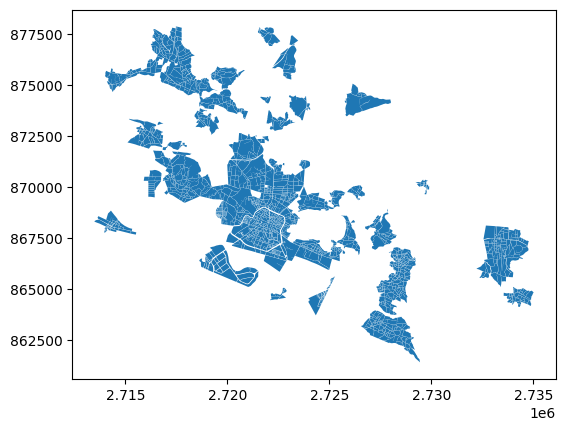

In [81]:
#Se filtra x la clave del municipio que se está trabajando
zona=zonas[zonas.CVE_MUN=='014']
zona.plot()

Cruce de zonas vs construcciones

In [82]:
#Base del cruce con areas rurales y urbanas   casas vs 15m
base_ur = gpd.sjoin(cruce_casasxpines,zona.to_crs(3857),how='left')
base_ur.rename(columns={'index_right':'ID_15m'},inplace=True)
base_ur.shape, cruce_casasxpines.shape

((69982, 52), (65394, 43))

In [83]:
len(base_ur.geometry.unique())

50839

In [85]:
base_ur[base_ur.geometry.isin(base_ur.geometry.value_counts()[base_ur.geometry.value_counts()>1].index)].tail(2)

,puntos,zona,area_left,rectangulo,Medida_lx,Medida_ly,Max_xy,Min_xy,f_lado,f_area,geometry,ID_ind,cve_ent,cve_mun,cve_loc,CLAVECATASTRAL,curt,notas,ID_curt,clase_dete,conf,area_right,status,ID_casas,CURT_f,CURT_si,dupGEO,dupCURT,YOLO_si,area,Ind_si,ID_chin,conf_pin,area_pin,angulo,Clase,umbral,n_resize,tipoCenCom,tipo_asent,nombre_act,clee,ID_denue,ID_15m,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA
58328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11104392.057 2245193.984, -11104377...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,casas,0.4304,NaN,correcto,58328.0,19455352909945082636,NaN,NaN,NaN,1.0,401.117906,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11981.0,1501400310248010,15,014,0031,0248,010,Rural,Típica
58328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-11104392.057 2245193.984, -11104377...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,casas,0.4304,NaN,correcto,58328.0,19455352909945082636,NaN,NaN,NaN,1.0,401.117906,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12988.0,1501400310248009,15,014,0031,0248,009,Rural,Típica


In [86]:
base_ur.columns

Index(['puntos', 'zona', 'area_left', 'rectangulo', 'Medida_lx', 'Medida_ly',
       'Max_xy', 'Min_xy', 'f_lado', 'f_area', 'geometry', 'ID_ind', 'cve_ent',
       'cve_mun', 'cve_loc', 'CLAVECATASTRAL', 'curt', 'notas', 'ID_curt',
       'clase_dete', 'conf', 'area_right', 'status', 'ID_casas', 'CURT_f',
       'CURT_si', 'dupGEO', 'dupCURT', 'YOLO_si', 'area', 'Ind_si', 'ID_chin',
       'conf_pin', 'area_pin', 'angulo', 'Clase', 'umbral', 'n_resize',
       'tipoCenCom', 'tipo_asent', 'nombre_act', 'clee', 'ID_denue', 'ID_15m',
       'CVEGEO', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB', 'CVE_MZA',
       'AMBITO', 'TIPOMZA'],
      dtype='object')

In [88]:
# Ejes de calles
ejes_path =r"H:\.shortcut-targets-by-id\1xy7wVmj8pxJHqeyV9CG1vOBQs3emChdq\Geo\Data\DELEGACIONES_EDOMEX\ATLACOMULCO_2018\ATLACOMULCO\Ejes_Atlacomulco.shp"
ejes = gpd.read_file(ejes_path)
ejes = ejes.to_crs(3857)
ejes.tail(2)

,STREETS,BANDA,geometry
4078,SIN NOMBRE,NaN,"LINESTRING (-11118819.088 2251137.177, -111188..."
4079,LA HUERTA,NaN,"LINESTRING (-11118793.631 2248974.329, -111187..."


In [89]:
cruce_ejes = base_ur.sjoin(ejes)
print(cruce_ejes.shape)
'Porcentaje a borrar: ',cruce_ejes.shape[0]/base_ur.shape[0]*100

(19436, 55)


('Porcentaje a borrar: ', 27.77285587722557)

In [90]:
import numpy as np 
print('Shape original: ', base_ur.shape)
index_drop = np.unique(base_ur[base_ur.geometry.isin(cruce_ejes.geometry)].index.values)
base_ur.drop(index=index_drop,inplace=True)
print('Shape final:    ', base_ur.shape)

Shape original:  (69982, 52)
Shape final:     (50767, 52)


In [91]:
base_ur.columns

Index(['puntos', 'zona', 'area_left', 'rectangulo', 'Medida_lx', 'Medida_ly',
       'Max_xy', 'Min_xy', 'f_lado', 'f_area', 'geometry', 'ID_ind', 'cve_ent',
       'cve_mun', 'cve_loc', 'CLAVECATASTRAL', 'curt', 'notas', 'ID_curt',
       'clase_dete', 'conf', 'area_right', 'status', 'ID_casas', 'CURT_f',
       'CURT_si', 'dupGEO', 'dupCURT', 'YOLO_si', 'area', 'Ind_si', 'ID_chin',
       'conf_pin', 'area_pin', 'angulo', 'Clase', 'umbral', 'n_resize',
       'tipoCenCom', 'tipo_asent', 'nombre_act', 'clee', 'ID_denue', 'ID_15m',
       'CVEGEO', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB', 'CVE_MZA',
       'AMBITO', 'TIPOMZA'],
      dtype='object')

In [92]:
try:
    base_ur = base_ur[['ID_casas','clase_dete','Clase','geometry','CLAVECATASTRAL', 'curt','CURT_f',
                        'puntos','zona','area_left', 'rectangulo', 'Medida_lx', 'Medida_ly','Max_xy',
                        'Min_xy', 'f_lado', 'f_area',  'ID_ind', 'cve_ent','cve_mun', 'cve_loc',  'notas', 
                        'ID_curt','conf', 'area_right', 'status','CURT_si', 'dupGEO', 'dupCURT','YOLO_si', 
                        'area', 'Ind_si', 'ID_chin','conf_pin', 'area_pin','angulo',  'umbral', 'n_resize',
                        'tipoCenCom', 'tipo_asent', 'nombre_act','clee', 'ID_denue', 'ID_15m','CVEGEO',
                        'CVE_ENT', 'CVE_MUN', 'CVE_LOC','CVE_AGEB', 'CVE_MZA','AMBITO', 'TIPOMZA']]
except:
   base_ur = base_ur[['ID_casas','clase_dete','Clase','geometry','CLAVECATASTRAL', 'curt','CURT_f',
                        'puntos','zona','area_left', 'rectangulo', 'Medida_lx', 'Medida_ly','Max_xy',
                        'Min_xy', 'f_lado', 'f_area',  'ID_ind', 'cve_ent','cve_mun', 'cve_loc',  'notas', 
                        'ID_curt','conf', 'area_right', 'status','CURT_si', 'dupGEO', 'dupCURT','YOLO_si', 
                        'area', 'Ind_si', 'ID_chin','conf_pin', 'area_pin','angulo',  'umbral', 'n_resize',
                        'tipoCenCom', 'tipo_asent', 'nombre_act','clee', 'ID_denue', 'ID_15m','CVEGEO',
                        'CVE_ENT', 'CVE_MUN', 'CVE_LOC','CVE_AGEB', 'CVE_MZA','AMBITO', 'TIPOMZA']]

In [93]:
base_ur.tail(3)

,ID_casas,clase_dete,Clase,geometry,CLAVECATASTRAL,curt,CURT_f,puntos,zona,area_left,rectangulo,Medida_lx,Medida_ly,Max_xy,Min_xy,f_lado,f_area,ID_ind,cve_ent,cve_mun,cve_loc,notas,ID_curt,conf,area_right,status,CURT_si,dupGEO,dupCURT,YOLO_si,area,Ind_si,ID_chin,conf_pin,area_pin,angulo,umbral,n_resize,tipoCenCom,tipo_asent,nombre_act,clee,ID_denue,ID_15m,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA
58500,58500.0,casas,NaN,"POLYGON ((-11099543.480 2242089.029, -11099532...",NaN,NaN,19441895799942316247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.62800,NaN,correcto,NaN,NaN,NaN,1.0,210.586900,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58501,58501.0,casas,NaN,"POLYGON ((-11099434.893 2243549.859, -11099430...",NaN,NaN,19450350719942281620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.24212,NaN,correcto,NaN,NaN,NaN,1.0,195.544979,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58502,58502.0,casas,NaN,"POLYGON ((-11099425.118 2242077.771, -11099392...",NaN,NaN,19441838869942275749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27316,NaN,correcto,NaN,NaN,NaN,1.0,649.811007,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
base_ur.to_file(r'I:\Mi unidad\Cruces_predial_otros\Atlacomulco\Bases_salida_limpieza\casas\NUEVO/Atlacomulco_casas_cruces_todos.shp',
                 index=False)